# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Rachel Pizatella

**Group:** Brenda Sciepura 

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

from sklearn.cluster import AgglomerativeClustering

import keras
from keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

2023-12-15 12:29:42.628852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 12:29:42.787851: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 12:29:42.792744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-15 12:29:42.792765: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

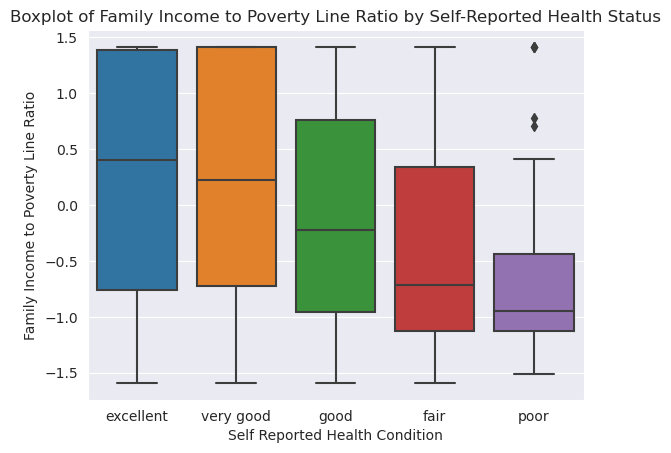

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

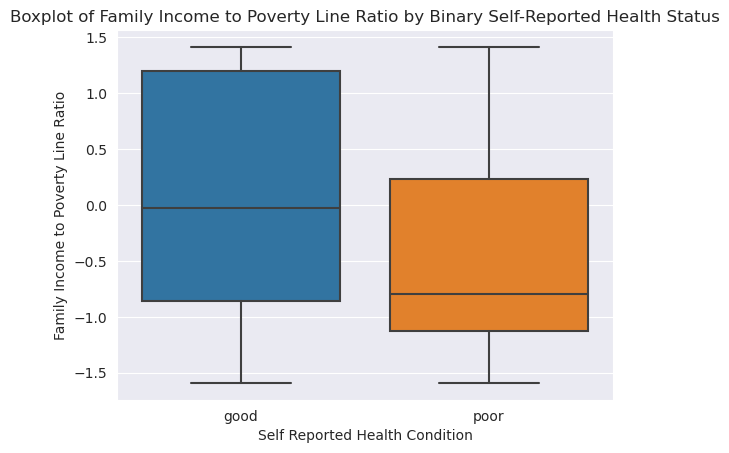

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

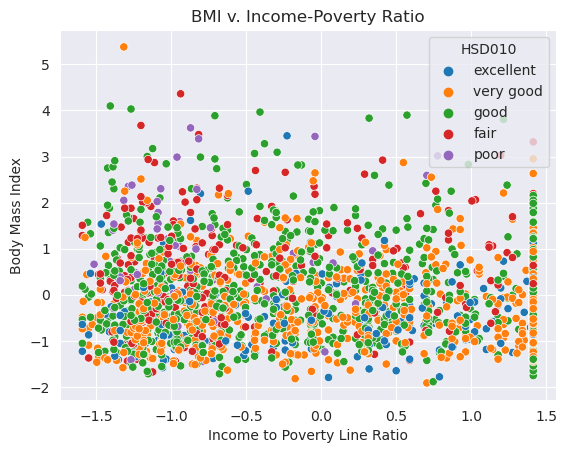

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
#nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [7]:
nhanes_scaled_unsupervised = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Answer 
**Number of components**
The scree plot shows the amount of variation explained by number of components. Visually, it drops significantly by 5 components and evens out almost completely with 50 components. I chose to sort of balance overall variation with individual variation, selecting 10 components. The barchart shows that 10 components capture just over 35% of the total variation, but components 6 through 10 capture very similar, small amounts. Therefore, I would not want to include many more components because the returns to each are quite small. 

**Scatterplot**
I include 3 scatterplots of principal component one and two. The latter two plots include labelled data, so we can visualize how the two most important components capture self reported health. The components overlap quite a bit, which makes sense because they explain less than 20% of the variation in the data. 


### Train PCA and Discuss Number of Components

In [8]:
## Your Answer Here

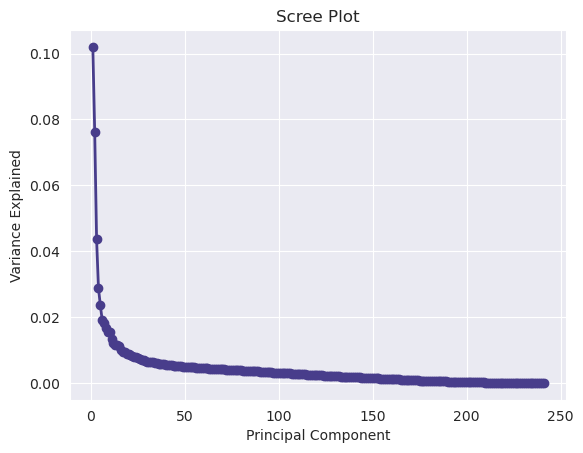

In [9]:
#
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA()  
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled_unsupervised)

# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='darkslateblue')  
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [10]:
# apply PCA
# ----------
pca = PCA(n_components=10)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_unsupervised)


In [11]:
pca_df = pd.DataFrame(data = principalComponents_nhanes, index=nhanes_scaled_unsupervised.index)  

### Barplot of Components

In [12]:
## Your Answer Here

In [13]:
# feature df
original_feature_names = nhanes_scaled_unsupervised.columns
components_df = pd.DataFrame(data=pca.components_, columns=original_feature_names)

# Display the components
components_df

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
0,1.987018e-18,-0.000643,2.857215e-22,0.004001,0.017487,0.002562,-0.010297,-0.007398,0.009323,-0.010322,...,-0.026669,0.017998,-0.023927,-0.011375,-0.030444,0.0,0.006748,-0.005185,-0.015929,0.005240
1,8.437758e-17,-0.006048,1.050223e-21,0.007050,0.002873,-0.021953,0.021641,0.008215,0.001760,-0.004650,...,0.101132,-0.064842,0.081683,-0.068165,0.025102,-0.0,-0.034293,0.025621,0.036517,0.078464
2,-3.147805e-17,-0.003972,7.031891e-19,-0.030757,-0.000433,-0.000210,0.003883,0.012123,-0.032110,0.031678,...,0.010706,-0.047218,0.038436,0.124067,0.105249,0.0,-0.064691,-0.001545,0.031943,-0.135729
3,-8.935435e-18,0.014559,8.831211e-18,-0.000298,-0.002063,-0.027037,-0.008476,-0.006377,0.040667,-0.028002,...,0.009824,-0.086672,0.089194,-0.194437,-0.047230,-0.0,-0.031781,-0.021127,0.028746,0.191388
4,3.727799e-17,-0.003825,5.173833e-17,-0.013871,0.000088,0.027233,0.116284,0.020173,-0.021368,0.021124,...,-0.005858,-0.001528,0.023233,-0.039772,0.020364,-0.0,0.048050,0.004110,0.026229,0.036690
5,-4.468919e-17,0.025672,2.545469e-17,-0.022004,-0.001448,-0.000824,-0.009416,-0.002124,0.013068,-0.004023,...,0.006262,0.004464,0.006716,0.001689,0.013167,0.0,-0.067698,-0.015379,-0.010344,-0.021979
6,-1.942393e-17,-0.001008,2.918057e-17,-0.011256,-0.007244,0.043366,-0.073573,0.004595,-0.012898,-0.005734,...,-0.012996,0.060448,-0.048427,0.102132,0.038361,-0.0,-0.040177,0.013472,-0.007372,-0.123162
7,-1.833145e-17,0.005854,2.421555e-17,0.008266,0.003551,-0.015317,-0.063971,0.031298,-0.043760,0.002442,...,-0.008406,0.032425,-0.035477,0.098486,0.026323,0.0,0.039573,0.004288,-0.052787,-0.106896
8,5.355517e-18,-0.000198,-3.054703e-17,0.021466,0.025106,-0.028037,-0.158228,0.037302,-0.042728,-0.018380,...,-0.012916,0.012231,-0.056104,0.025730,-0.012753,0.0,-0.044716,-0.007174,-0.050359,-0.025074
9,2.603460e-17,0.045470,2.046997e-17,-0.009973,0.001312,0.012389,0.180749,0.045772,-0.070017,0.056431,...,-0.016000,0.057074,0.004904,0.071628,0.001578,0.0,0.077091,0.036749,0.033957,-0.056939


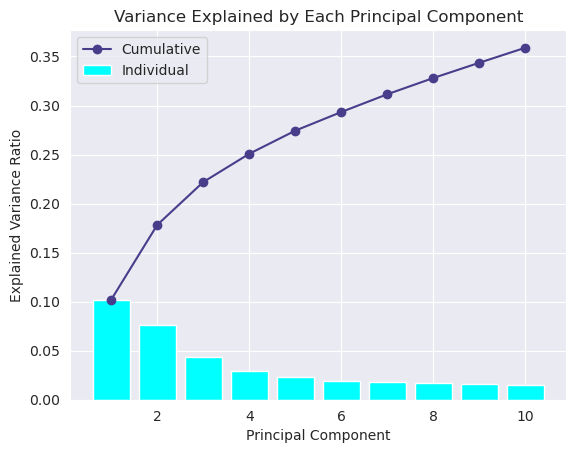

In [14]:
# Plot the explained variance ratio
# ----------
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Bar plot
fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Individual', color='aqua')  # Set bar color to aqua
ax.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, label='Cumulative', marker='o', color='darkslateblue')  # Set point color to darkslateblue
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Variance Explained by Each Principal Component')
ax.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

In [15]:
## Your Answer Here

In [16]:
pca_df

,0,1,2,3,4,5,6,7,8,9
SEQN,,,,,,,,,,
73568,9.527811,-0.816224,-1.867093,-2.109947,-3.930348,-0.181127,-3.836494,-2.916995,1.536003,0.665921
73576,-5.838339,-3.692573,3.805741,-1.029830,0.392172,1.599880,2.723469,-0.722118,0.405775,-2.434641
73579,-0.719454,-2.573201,0.907910,-4.755687,-1.799391,0.863466,-1.015550,0.637616,0.555789,0.422637
73581,3.533627,-2.576982,-3.249124,-0.405652,3.998479,1.447484,-1.180624,0.348050,-4.137647,-1.225004
73584,-6.872094,-4.194240,0.886838,-0.848768,-0.523703,0.068934,0.837677,0.976248,0.547530,-0.039848
...,...,...,...,...,...,...,...,...,...,...
83694,2.643319,-1.689356,-0.702600,-0.538467,-1.022773,-0.672694,0.473057,-0.283898,0.964196,-1.243223
83696,1.037906,-0.118065,5.556456,1.630473,0.968044,1.143009,1.954622,0.931717,-1.268643,-2.034100
83704,1.130253,-0.970432,3.415391,1.206617,-3.632968,1.120375,1.355604,1.816274,-2.338266,0.240043


In [17]:
#
# using PCA Features
# --------------------------------------------------------


# create target dataset
# ----------
y = nhanes_scaled['HSD010']


# create features dataset 
# ----------
X = pca_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

In [18]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')


Accuracy: 0.4431



### 2D Scatterplot of the first two components

In [19]:
## Your Answer Here

In [20]:
pca = PCA(n_components=2)
principalComponents_nhanes = pca.fit_transform(pca_df)

pca_df_2comps = pd.DataFrame(data = principalComponents_nhanes,
                             columns = ['principal component 1', 
                                 'principal component 2'])

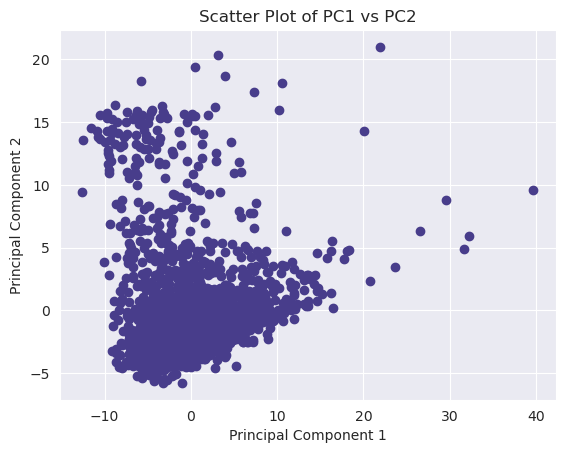

In [21]:
plt.scatter(pca_df_2comps['principal component 1'], pca_df_2comps['principal component 2'], color='darkslateblue')
plt.title('Scatter Plot of PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

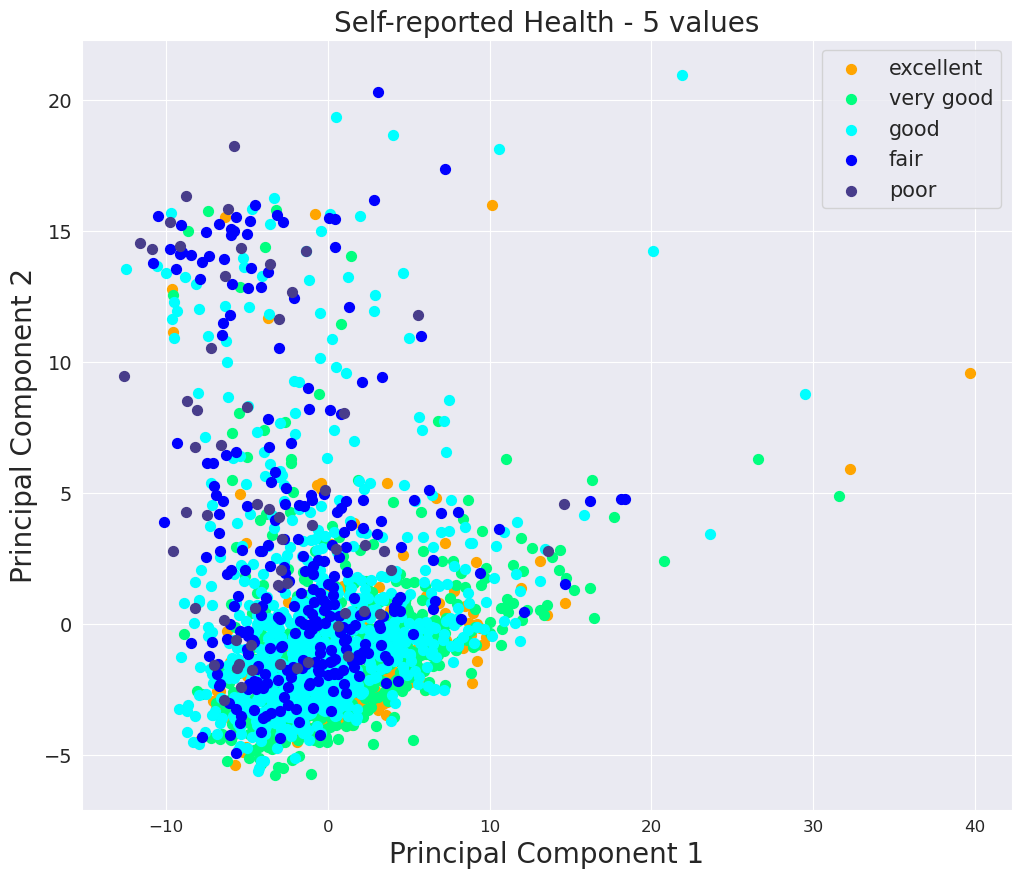

In [22]:
# figure settings
plt.figure(figsize=(12, 10))  # Adjusted figure size for better fit
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Self-reported Health - 5 values", fontsize=20)  
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['orange', 'springgreen', 'aqua', 'b', 'darkslateblue']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = nhanes_scaled['HSD010'].reset_index(drop=True) == target
    plt.scatter(
        pca_df_2comps.loc[indicesToKeep, 'principal component 1'],
        pca_df_2comps.loc[indicesToKeep, 'principal component 2'],
        c=color,
        s=50,
        label=target
    )

# Format
plt.legend(prop={'size': 15}, loc='upper right')
plt.show()

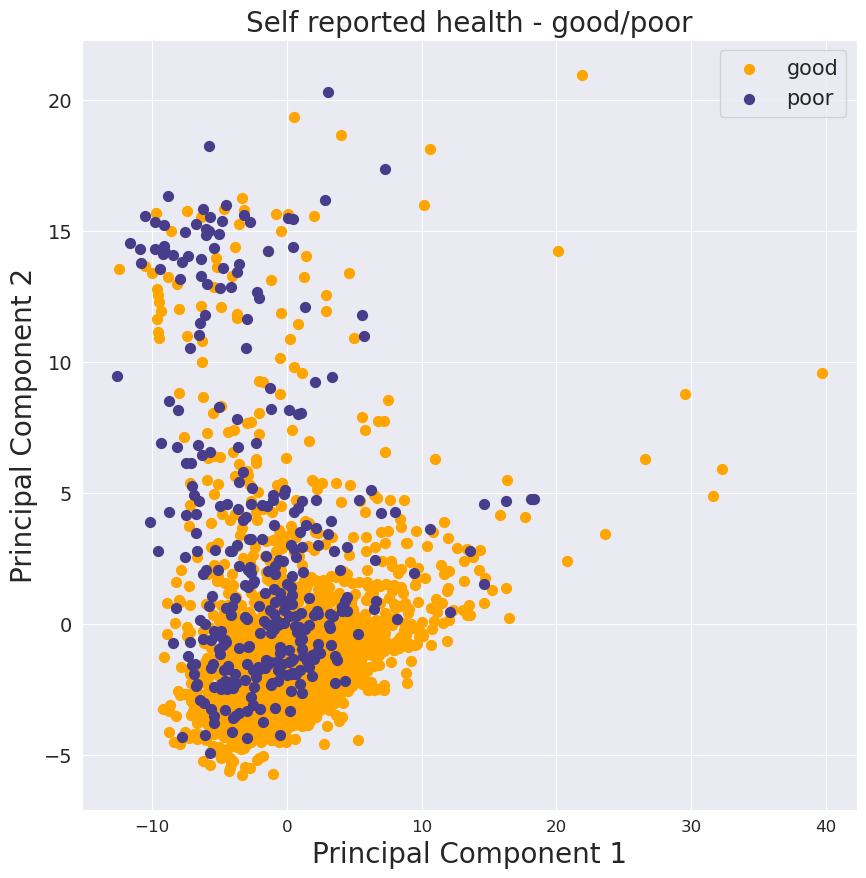

In [23]:
# figure settings
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Self reported health - good/poor", fontsize=20)

targets = ['good', 'poor']
colors = ['orange', 'darkslateblue']  

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Resetting the index of the boolean series
    indicesToKeep = nhanes_scaled['HSD010_binary'].reset_index(drop=True) == target
    plt.scatter(
        pca_df_2comps.loc[indicesToKeep, 'principal component 1'],
        pca_df_2comps.loc[indicesToKeep, 'principal component 2'],
        c=color,
        s=50,
        label=target
    )

# format
plt.legend(prop={'size': 15})
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Answer 
**Clustering**
We learned about three types of clustering. I am testing out both k-means and hierarchical clustering. 

The k-means algorithm identifies clusters by:
1. Randomly assigning cases to pre-selected number of clusters; and 
2. Repeatedly calculating the centroid of the clusters and re-assigning each case to its nearest centroid until the clusters are stable. 

Hierarchical clustering includes top down and bottom up. The agglomerative clustering algorithm creates a cluster for each point and fuses that cluster to the nearest point until. This process continues until it reaches the pre-selected number of clusters. 

**Choices**
I chose the number of clusters based on the number of outcomes of my label, which is 5. 

**Scatterplot**
I include outputs for both k means and agglomerative clustering. The scatterplot on the left is the original BMI vs. income with the health labels for colors. The scatterplot on the left also plots BMI vs. income but includes cluster groups instead of health labels. We would expect that high BMI and low income is associated with poor self reported health. However, the scatterplot seems fairly random. Both clustering algorithms do a slightly better job of separating the data, suggesting that there may be an important relationship between BMI and income but it's not being captured by self reported health alone. 

**Results of training**
Combining clustering (I chose k means) with PCA shows that the clusters are better explained by the components than the self reported health outcomes. Similar to the result above, it seems like there are groups not being captured by self reported health alone. 


### Choose a Clustering Algorithm

In [24]:
## Your Answer Here

#### K means

In [25]:
# set random seed
np.random.seed(10)

In [26]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_unsupervised)

In [27]:
# Get the cluster labels assigned to each data point
labels = kmeans.labels_
labels

array([3, 4, 4, ..., 4, 3, 2], dtype=int32)

In [28]:
## creating the centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=nhanes_scaled_unsupervised.columns)
centers

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
0,0.0,-0.044728,0.0,-0.104559,-0.084496,-0.109332,0.160159,-0.019375,0.055591,-0.077691,...,0.264849,-0.545119,0.554773,-0.472287,0.216875,0.0,-0.208017,0.041421,0.364954,0.465555
1,0.0,-0.094412,0.0,0.143323,-0.003795,-0.205411,0.166909,0.097307,-0.028501,-0.044974,...,1.154792,-0.552849,0.662673,-0.484200,0.319451,0.0,-0.305311,0.297702,0.332787,0.612440
2,0.0,0.045676,0.0,0.064890,-0.039577,0.023221,-0.071619,-0.057306,0.091772,-0.063032,...,-0.226788,0.235816,-0.216029,-0.376019,-0.427426,0.0,0.233964,-0.099474,-0.188403,0.380611
3,0.0,0.007262,0.0,0.026137,0.177433,-0.008052,-0.006924,0.016711,0.015285,-0.030644,...,-0.113314,0.137343,-0.155138,-0.043469,-0.144386,0.0,-0.010221,-0.001779,-0.089558,-0.002615
4,0.0,-0.004263,0.0,-0.080526,-0.004963,0.159344,-0.100116,0.069300,-0.223691,0.238420,...,-0.207517,0.242867,-0.312108,1.382031,0.535332,0.0,-0.066356,0.021373,-0.097379,-1.387673


In [29]:
## adding the label 
nhanes_scaled_kmeans = nhanes_scaled.assign(label = kmeans.labels_.astype(str))

#### Agglomerative

In [30]:
# run algorithm
# ----------
ward = AgglomerativeClustering(n_clusters=5, linkage='ward', affinity='euclidean')

In [31]:
# fit to data 
# ----------
ward.fit(nhanes_scaled_unsupervised)

AgglomerativeClustering(n_clusters=5)

In [32]:
## adding the label 
nhanes_scaled_agglomerative = nhanes_scaled.assign(label = ward.labels_.astype(str))

### Cluster nhanes

In [33]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

#### K means 

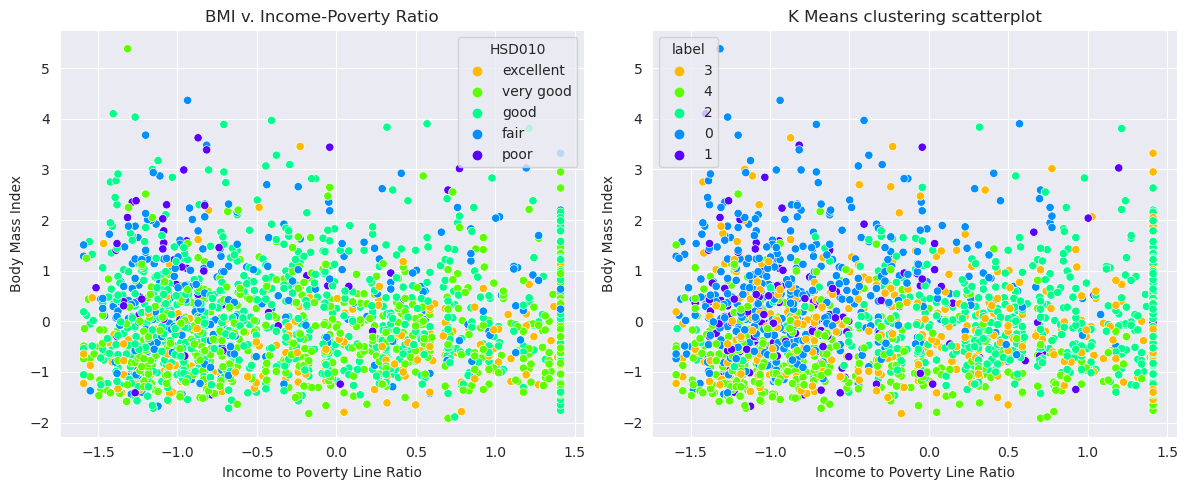

In [34]:
# Set up the figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="gist_rainbow", data=nhanes_scaled, ax=axes[0])
axes[0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[0].set_title("BMI v. Income-Poverty Ratio")

# Plot 2
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="label", palette="gist_rainbow", data=nhanes_scaled_kmeans, ax=axes[1])
axes[1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[1].set_title("K Means clustering scatterplot")

# Format
plt.tight_layout()
plt.show()

#### Agglomerative 

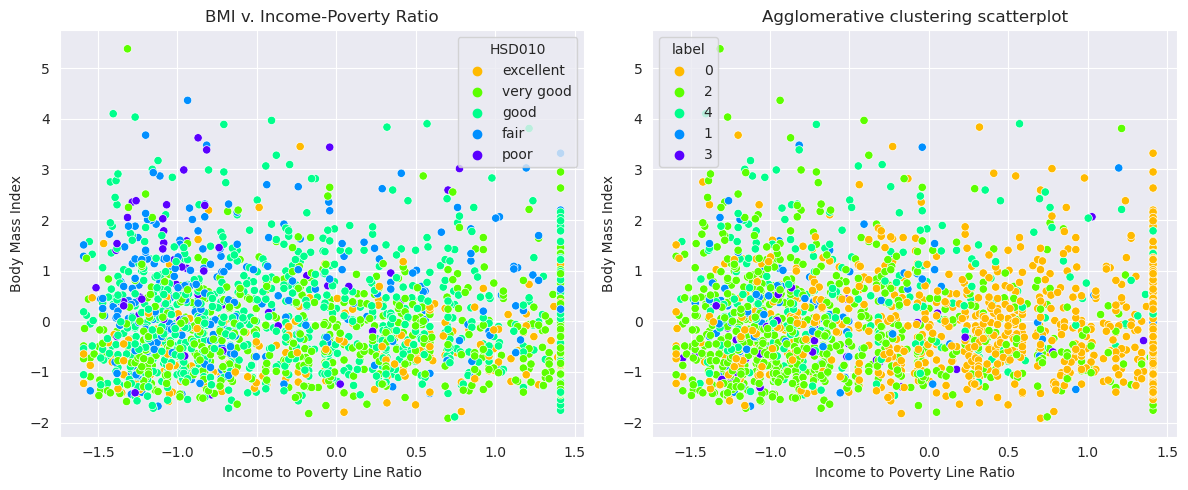

In [35]:
# Set up the figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="gist_rainbow", data=nhanes_scaled, ax=axes[0])
axes[0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[0].set_title("BMI v. Income-Poverty Ratio")

# Plot 2
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="label", palette="gist_rainbow", data=nhanes_scaled_agglomerative, ax=axes[1])
axes[1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[1].set_title("Agglomerative clustering scatterplot")

# format
plt.tight_layout()
plt.show()

In [36]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [37]:
## Your Answer Here

In [38]:
# set random seed
np.random.seed(10)

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 
                ).fit(pca_df)

In [39]:
## adding the label
pca_kmeans_fit = pca_df.assign(label = kmeans.labels_.astype(str))

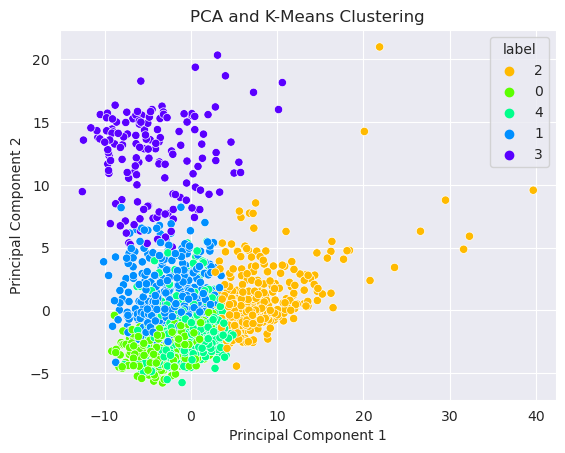

In [40]:
# Plotting
ax = sns.scatterplot(x=0, y=1, hue="label", 
                     palette="gist_rainbow", 
                     data=pca_kmeans_fit)

# Format
ax.set_title("PCA and K-Means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show()

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Answer 

**Comparing algorithms**
I run the same algorithm to predict health status on 3 different types of features. First, I include all the features from the nhanes dataset, which resulted in an accuracy score of 43%. Second, I run it with just the components from the PCA unsupervised learned which resulted in the lowest accuracy score. Finally, I run it on the PCA features and the clusters which results in a similar accuracy score to the first algorithm. 

I do think dimension reduction is helpful, but given that the results are similar for the original features and PCA, I might select the original features because its more transparent. Explaining eigenvalues to a policymaker seems difficult. 

In addition, I chose 10 components because choosing many more than that seems like it defeats the purpose of dimensionality reduction. However, I think my models that used the components as features would have performed better if I had included more components. 

### Neural Network on Original Features

In [41]:
# partition data
# -----------
y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
y = y.astype('category').cat.codes

X = nhanes_scaled.drop(columns=['HSD010_binary', 'HSD010']) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [42]:
num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [43]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(num_classes, 
                input_dim= X_train.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model.add(Dense(num_classes, 
                kernel_initializer= 'normal', 
                activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy'])

model.fit(X_train, 
          y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=200, 
          verbose=2)

2023-12-15 12:29:53.774267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-15 12:29:53.774303: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-15 12:29:53.774325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rachel-5fpizatella): /proc/driver/nvidia/version does not exist
2023-12-15 12:29:53.774692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
8/8 - 1s - loss: 1.5959 - accuracy: 0.3618 - val_loss: 1.5837 - val_accuracy: 0.4070 - 846ms/epoch - 106ms/step
Epoch 2/10
8/8 - 0s - loss: 1.5766 - accuracy: 0.4121 - val_loss: 1.5644 - val_accuracy: 0.4109 - 50ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.5569 - accuracy: 0.4289 - val_loss: 1.5434 - val_accuracy: 0.4186 - 49ms/epoch - 6ms/step
Epoch 4/10
8/8 - 0s - loss: 1.5347 - accuracy: 0.4425 - val_loss: 1.5205 - val_accuracy: 0.4322 - 46ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.5096 - accuracy: 0.4535 - val_loss: 1.4960 - val_accuracy: 0.4302 - 45ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 1.4834 - accuracy: 0.4477 - val_loss: 1.4709 - val_accuracy: 0.4419 - 45ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 1.4568 - accuracy: 0.4554 - val_loss: 1.4468 - val_accuracy: 0.4419 - 43ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 1.4320 - accuracy: 0.4593 - val_loss: 1.4245 - val_accuracy: 0.4419 - 48ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.4081 - 

In [44]:
# evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Feature Accuracy: {accuracy*100:.2f}%')

17/17 - 0s - loss: 1.3849 - accuracy: 0.4457 - 45ms/epoch - 3ms/step
Feature Accuracy: 44.57%


### Neural Network on Principal Components

In [45]:
## Your Answer Here

In [46]:
# partition data
# -----------
y_pca = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
y_pca = y.astype('category').cat.codes

X_pca = pca_df # drop out any columns that aren't features

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, 
                                                    y_pca, 
                                                    test_size = .25, 
                                                    random_state = 10)


num_classes = 5
# convert class vectors to binary class matrices
y_train_pca = keras.utils.to_categorical(y_train_pca, num_classes)
y_test_pca = keras.utils.to_categorical(y_test_pca, num_classes)
num_classes = y_test_pca.shape[1]

# create neural network model
# -----------
model_pca = Sequential()

model_pca.add(Dense(num_classes, 
                input_dim= X_train_pca.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_pca.add(Dense(num_classes, 
                kernel_initializer= 'normal', 
                activation= 'softmax'))

## Add any additional layers you wish here

model_pca.compile(loss= 'categorical_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy'])

model_pca.fit(X_train_pca, 
          y_train_pca, 
          validation_data=(X_test_pca, y_test_pca), 
          epochs=10, 
          batch_size=200, 
          verbose=2)

Epoch 1/10
8/8 - 1s - loss: 1.6082 - accuracy: 0.2410 - val_loss: 1.6042 - val_accuracy: 0.3236 - 689ms/epoch - 86ms/step
Epoch 2/10
8/8 - 0s - loss: 1.5997 - accuracy: 0.3463 - val_loss: 1.5958 - val_accuracy: 0.3721 - 45ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.5914 - accuracy: 0.3889 - val_loss: 1.5873 - val_accuracy: 0.3876 - 43ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 1.5829 - accuracy: 0.3960 - val_loss: 1.5783 - val_accuracy: 0.3934 - 44ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 1.5731 - accuracy: 0.4012 - val_loss: 1.5688 - val_accuracy: 0.3973 - 43ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 1.5630 - accuracy: 0.3979 - val_loss: 1.5580 - val_accuracy: 0.3953 - 46ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 1.5516 - accuracy: 0.3979 - val_loss: 1.5463 - val_accuracy: 0.3953 - 46ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 1.5390 - accuracy: 0.3986 - val_loss: 1.5335 - val_accuracy: 0.3953 - 45ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.5254 - a

In [47]:
# evaluate
loss, accuracy = model_pca.evaluate(X_test_pca, y_test_pca, verbose=2)
print(f'PCA Accuracy: {accuracy*100:.2f}%')

17/17 - 0s - loss: 1.5052 - accuracy: 0.4070 - 42ms/epoch - 2ms/step
PCA Accuracy: 40.70%


### Neural Network on Principal Components + Cluster Membership

In [48]:
## Your Answer Here

In [49]:
# partition data
# -----------
y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary
y = y.astype('category').cat.codes # converting to numeric

## adding cluster membership 
pca_feature_label = pca_df.join(nhanes_scaled_kmeans[['label']], how='inner')

X_clust = pca_feature_label # drop out any columns that aren't features
X_clust['label'] = X_clust['label'].astype('category').cat.codes ## converting label to numeric 

X_train_clust, X_test_clust, y_train, y_test = train_test_split(X_clust, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 5

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [50]:
# create neural network model
# -----------
model_best = Sequential()

model_best.add(Dense(num_classes, 
                input_dim= X_train_clust.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_best.add(Dense(num_classes, 
                kernel_initializer= 'normal', 
                activation= 'softmax'))

## Add any additional layers you wish here

model_best.compile(loss= 'categorical_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy'])

model_best.fit(X_train_clust, 
          y_train, 
          validation_data=(X_test_clust, y_test), 
          epochs=10, 
          batch_size=200, 
          verbose=2)

Epoch 1/10
8/8 - 1s - loss: 1.6115 - accuracy: 0.2429 - val_loss: 1.6035 - val_accuracy: 0.3023 - 685ms/epoch - 86ms/step
Epoch 2/10
8/8 - 0s - loss: 1.6000 - accuracy: 0.3081 - val_loss: 1.5923 - val_accuracy: 0.3256 - 44ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.5884 - accuracy: 0.3372 - val_loss: 1.5812 - val_accuracy: 0.3508 - 44ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 1.5769 - accuracy: 0.3475 - val_loss: 1.5695 - val_accuracy: 0.3469 - 44ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.5645 - accuracy: 0.3553 - val_loss: 1.5571 - val_accuracy: 0.3624 - 48ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 1.5511 - accuracy: 0.3611 - val_loss: 1.5437 - val_accuracy: 0.3702 - 46ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 1.5368 - accuracy: 0.3643 - val_loss: 1.5294 - val_accuracy: 0.3740 - 47ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 1.5216 - accuracy: 0.3695 - val_loss: 1.5143 - val_accuracy: 0.3740 - 46ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.5053 - a

In [51]:
# evaluate
loss, accuracy = model_best.evaluate(X_test_clust, y_test, verbose=2)
print(f'Test Accuracy: {accuracy*100:.2f}%')

17/17 - 0s - loss: 1.4832 - accuracy: 0.3876 - 48ms/epoch - 3ms/step
Test Accuracy: 38.76%


## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here
Clustering and PCA are similar in that they are unsupervised methods, meaning they don't require labels. Instead, they are used to make sense of data with multiple features by identifying patterns in the features. The methods differ in the way that they give structure to the data. 

**Clustering** Clustering partitians the data into groups. Clustering sorts observations based on features groups of observations have in common. Each observation is assigned to a cluster. This results in one new feature which records the groupings. 

**PCA** PCA is a form of dimensionality reduction. Instead of grouping observations together, it groups features together based on how much variation the features explain in the data when put together. The result are multiple new features called principal components that are collections of original features. 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here
The advantage of combining the two techniques was obvious in the scatterplot of the components with the cluster labels. You can clearly see how clustering improved the PCA by creating distinct groups where the PCA alone left a lot of overlap. 

The disadvantage is that without much domain knowledge, it's difficult to interpret what the groups might mean. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

## Your Answer Here

Unsupervised machine learning is a helpful pre-processing step before conducting the main analysis. There are a few ways to use unsupervised machine learning for supervised learning tasks. First, it provides a disciplined way to assess the importantance of covariates, which could help to address ommitted variable bias in causal inference. PCA could be used to identify important features or the components could be used as features. 

Second, clustering could be used to inform subgroup analysis. Different groups may be differentially impacted by policies and programs. Clustering offers a way to test assumptions about the relationship between groups (based on a collection of features) and the outcome of interest based on domain knowledge. It also offers guidance on how to examine heterogeneous effects. 